# Here we go again...

In [1]:
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.config.model_args import ModelArgs
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import os
import re
import warnings
warnings.filterwarnings('ignore')

## Read data

When running the function, input the path to where the desired dataset(s) is/are located.

In [2]:
def read_data(path): #input the path to the directory with data
    frames = []
    
    _, _, files = next(os.walk(path)) #create a list of all datafile names     
          
    for file in tqdm(files): #for every file in directory
        with open(path+"/"+file) as f: #read each file
            dataframe = pd.read_json(f) #convert file to dataframe
     
        frames.append(dataframe) #append each dataframe to list
    data = pd.concat(frames, sort=False) #make it one big dataframe
    
    return data, frames

In [3]:
data, data_list = read_data("subset_v3")

  0%|          | 0/28 [00:00<?, ?it/s]

## Encoding entire dataset

When running the function that encodes the dataset, make sure the dataset is formatted as a list of dataframes - the 2nd object that's returned from the ```read_data``` function.

In [51]:
def remove_symbols(text):
    return re.sub('\W+',' ', text)

In [7]:
def encode_dataset(dataset, training_epochs=1): #input dataset as a list of dataframes
      
    model_args = ModelArgs(encoding="utf-8", manual_seed=42, num_train_epochs=training_epochs)

    print("Initializing Representation Model")
    model = RepresentationModel(
                model_type='bert',
                model_name='Maltehb/danish-bert-botxo',
                args=model_args,
                use_cuda=False)

    bodies = []
    authors = []
    domains = []
    
    
    for i, datafile in enumerate(tqdm(dataset)): #for each datafile
        
        body_list = list(datafile.Body)
        author_list = list(datafile.Byline)
        domain_list = list(datafile.Domain)
        header_list = list(datafile.Header)
        
        #save labels
        np.save(f"auto_encodings/authors_{i}", author_list)
        np.save(f"auto_encodings/domains_{i}", domain_list)
        np.save(f"auto_encodings/headers_{i}", header_list)
        
        clean_bodies = []
        
#         print(f"Cleaning bodies in datafile no. {i}")
        
        #clean bodies from punctuation and lowercase words
        for text in body_list: 
            text = remove_symbols(text)
            text = text.lower()
            clean_bodies.append(text)
            
        print(f"Encoding bodies in datafile no. {i}")
        
        #encode cleaned bodies
        word_vectors = model.encode_sentences(clean_bodies, combine_strategy='mean') 
  
        print(f"Saving encodings of datafile no. {i}") 
    
        #save encodings to file numbered with matching index of current datafile
        np.save(f"auto_encodings/encodings_{i}", word_vectors) 
        
    print("Data saved o/\o")
    
    return None #should save encodings and their labels (author, domain, header)

In [34]:
test_frames = []

for frame in data_list[:10]: 
    test_frames.append(frame[:500])
len(test_frames[0])

500

In [35]:
%%time
encode_dataset(test_frames)

Initializing Representation Model


Some weights of the model checkpoint at Maltehb/danish-bert-botxo were not used when initializing BertForTextRepresentation: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/10 [00:00<?, ?it/s]

Encoding bodies in datafile no. 0
Saving encodings of datafile no. 0
Encoding bodies in datafile no. 1
Saving encodings of datafile no. 1
Encoding bodies in datafile no. 2
Saving encodings of datafile no. 2
Encoding bodies in datafile no. 3
Saving encodings of datafile no. 3
Encoding bodies in datafile no. 4
Saving encodings of datafile no. 4
Encoding bodies in datafile no. 5
Saving encodings of datafile no. 5
Encoding bodies in datafile no. 6
Saving encodings of datafile no. 6
Encoding bodies in datafile no. 7
Saving encodings of datafile no. 7
Encoding bodies in datafile no. 8
Saving encodings of datafile no. 8
Encoding bodies in datafile no. 9
Saving encodings of datafile no. 9
Data saved o/\o
CPU times: total: 52min 50s
Wall time: 27min 4s


### Loading encodings from saved files

In [36]:
def load_autoencodings(path): 
    
    _,_, files = next(os.walk(path))

    encoding_arrays = []
    authors_labels = []
    domains_labels = []
    headers_labels = []
    
    for file in tqdm(files):
#         print(file)
        if 'encoding' in file: 
            encodings = np.load(path+'/'+file)
            encoding_arrays.append(encodings)
                
        if 'authors' in file: 
            authors = np.load(path+'/'+file)
            authors_labels.append(authors)
                
        if 'domains' in file: 
            domains = np.load(path+'/'+file)
            domains_labels.append(domains)
                
        if 'headers' in file: 
            headers = np.load(path+'/'+file)
            headers_labels.append(headers)
            
    encoding_arrays = np.concatenate(encoding_arrays, axis=0)
                
    return encoding_arrays, np.hstack(authors_labels), np.hstack(domains_labels), np.hstack(headers_labels)

In [37]:
encodings, authors, domains, headers = load_autoencodings("auto_encodings")       

  0%|          | 0/40 [00:00<?, ?it/s]

In [38]:
len(encodings), len(authors), len(domains), len(headers)

(5000, 5000, 5000, 5000)

In [52]:
domains_set = set(domains)
list_domains = list(domains)
domain_counts = {name:list_domains.count(name) for name in domains_set}

authors_set = set(authors)
list_authors = list(authors)
author_counts = {name:list_authors.count(name) for name in authors_set}
# domain_counts, author_counts

## Classification

In [40]:
# %%time
# comb = politiken+information+ekstrabladet+finans+berlingske+dr+tv2+version2+bt+jyllandsposten
# comb2 = politiken2+information2+ekstrabladet2+finans2+berlingske2+dr2+tv22+version22+bt2+jyllandsposten2


# model_args = ModelArgs(encoding="utf-8", manual_seed=42, num_train_epochs=1)

# model = RepresentationModel(
#         model_type='bert',
#         model_name='Maltehb/danish-bert-botxo',
#         args=model_args,
#         use_cuda=False)

# word_vectors = model.encode_sentences(bodies, combine_strategy='mean')

In [41]:
# word_vectors.shape

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [43]:
y = [0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100 + [5]*100 + [6]*100
# y = [0]*1000 + [1]*1000 + [2]*1000 + [3]*1000 + [4]*1000 + [5]*1000 +[6]*1000

train_X, test_X, train_y, test_y = train_test_split(encodings, domains)
# test_y

In [44]:
rfc = RandomForestClassifier().fit(train_X, train_y)

In [45]:
rfc.score(test_X, test_y)

0.8912

In [46]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import *

dum = DummyClassifier().fit(train_X, train_y)
dum.score(test_X, test_y)

0.5152

In [47]:
import classifier_unit_test
import matplotlib.pyplot as plt

In [48]:
tpr_fpr = classifier_unit_test.test_classifier(rfc, train_X, test_X, train_y, test_y, give_roc=True)

Oh, model already fit. Thanks!
Training dummy...
Correctly predicted 1114 of 1250	Dummy: 644 of 1250	:-)
Accuracy: 0.89			Dummy: 0.52	:-)
Balanced accuracy: 0.51		Dummy: 0.09	:-)
F1 score: 0.86			Dummy: 0.35	:-)
ROC AUC: 0.92			Dummy: 0.50	:-)

Output keys:
tpr
fpr
dum_tpr
dum_fpr


In [49]:
true_pos_rate = tpr_fpr["tpr"]
false_pos_rate = tpr_fpr["fpr"]
dum_tpr = tpr_fpr["dum_tpr"]
dum_fpr = tpr_fpr["dum_fpr"]

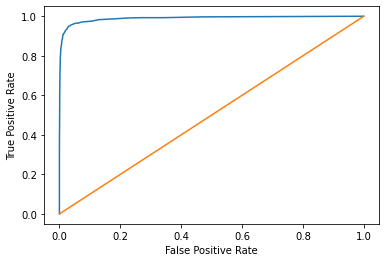

In [50]:
plt.plot(false_pos_rate, true_pos_rate)
plt.plot(dum_tpr,dum_fpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# Test the shit on codified

In [24]:
codified = np.load('../../../codified.npy')
codified.shape

FileNotFoundError: [Errno 2] No such file or directory: '../../../codified.npy'

In [ ]:
text = list(data.Header.astype(str))
texts = text
final_text = ''
for text in tqdm(texts):
    text = text.strip()
    text = text.replace('\n','')
    text = text.replace('\r','')
    text = text.replace('\t','')
    if len(text) < 10:
        continue
    final_text += ''.join(text)
    final_text += '\n'
final_text = final_text[:-1]

headers = final_text.split('\n')

In [ ]:
politiken2_ind = []
information2_ind = []
politiken2 = []
information2 = []

for i, header in tqdm(enumerate(headers)):
    if header in politiken:
        politiken2_ind.append(i)
    elif header in information:
        information2_ind.append(i)
    
    if len(politiken2) == 1000 and len(information2)==1000:
        break

In [ ]:
politiken2_vecs = np.array([codified[i] for i in politiken2_ind])
information2_vecs = np.array([codified[i] for i in information2_ind][:992])
codified_vecs = np.vstack((politiken2_vecs, information2_vecs))

y = [0]*992 + [1]*992
train_X, test_X, train_y, test_y = train_test_split(codified_vecs, y)

In [ ]:
# random.shuffle(y)
# train_X, test_X, train_y, test_y = train_test_split(codified_vecs, y)

In [ ]:
import classifier_unit_test

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
classifier_unit_test.test_classifier(rfc, train_X, test_X, train_y, test_y)

In [ ]:
auc

# Generation test

In [ ]:
#Make vector of some articles
bodies = list(data["Body"])[9000:9100]
headers = list(data["Header"])[9000:9100]

model = RepresentationModel(
        model_type='bert',
        model_name='Maltehb/danish-bert-botxo',
        use_cuda=False)

vectors = model.encode_sentences(bodies, combine_strategy='mean')
vectors.shape

In [ ]:
train_data = [[vectors[i], headers[i]] for i in range(len(headers)-10)]
eval_data = [[vectors[i], headers[i]] for i in range(len(headers)-10, len(headers))]
train_df = pd.DataFrame(train_data, columns=["input", "target"])
eval_df = pd.DataFrame(eval_data, columns=["input", "target"])
train_df.head()

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
import torch

tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")
embeddings = model.get_input_embeddings()